# Implementing Configuration, Degree-Preserving, and Hidden Parameter Models 
Romero, Matthew C.  
AIM - MSDS 2021

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scipy
import random

from itertools import combinations
from collections import Counter

from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import binom

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Generating Networks with Arbitrary Degree Distribution
In the Erdős-Renyi Model, we observed that the networks have a Poisson degree distribution. This is often true with random network models. But the same logic is not applicable for real networks as their degree distribution are very different and deviates from having a Poisson distribution. We could consider these networks as having an arbitrary $P_k$. How can we generate networks having a changing or arbitrary $P_k$? 

## Why Real Networks Are Not Poisson
Based on previous learnings, a node can have a degree $k$ between 0 and $N$-1 in a Random Network. To understand this better, let's investigate a Social Media network. Sociologists estimate that a typical person knows about 1000 acquaintances. Thus, we can say that a person $N$ has an estimated $<k>$=1000 links to him/her. If there are about 7,000,000,000 in the world, we draw some conclusions:

- The node with the largest degree has a $k$ of 1185 whilst the node with the smallest degree has a $k$ of 816. 
- We estimate that each node has a number of acquantainces between 968 and 1032. This can be calculated by getting the degree of dispersion of a random network $σ_k$ = $<k>^{1/2}$. In this case $σ_k$ = $1000^{1/2}$ is equal to around 31.62. This value is ± the original $<k>$

These conclusions are sound for a Random Network. We can plot the distributions of the degrees and we will get a poisson distribution. We show a smaller scale implementation below via the Erdős-Renyi Model.

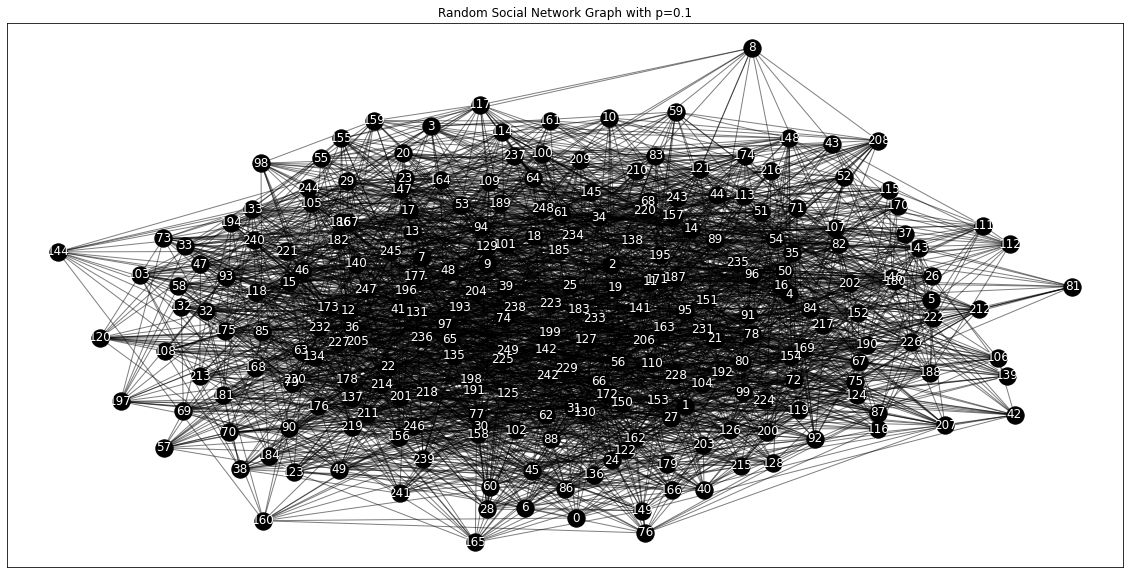

In [2]:
plt.figure(figsize=(20,10))
ER = nx.erdos_renyi_graph(n=250,p=0.1)
pos = nx.fruchterman_reingold_layout(ER)
nc = nx.draw_networkx_nodes(ER, pos=pos, node_size=300, cmap=plt.cm.RdYlBu,
                            node_color='black');
nx.draw_networkx_edges(ER, pos=pos, alpha=0.500);
nx.draw_networkx_labels(ER, pos=pos, font_color='white');
plt.title('Random Social Network Graph with p=0.1')
plt.show()

In [3]:
def distribution_graph(g): 
    print(nx.degree(g)) 
    all_node_degree = list(dict((nx.degree(g))).values()) 
  
    unique_degree = list(set(all_node_degree)) 
    unique_degree.sort() 
    nodes_with_degree = [] 
    for i in unique_degree: 
        nodes_with_degree.append(all_node_degree.count(i)) 
  
    plt.plot(unique_degree, nodes_with_degree) 
    plt.xlabel("Degrees") 
    plt.ylabel("No. of nodes") 
    plt.title("Degree distribution") 
    plt.show()

[(0, 16), (1, 30), (2, 29), (3, 20), (4, 30), (5, 20), (6, 21), (7, 25), (8, 13), (9, 25), (10, 18), (11, 30), (12, 29), (13, 27), (14, 28), (15, 26), (16, 24), (17, 25), (18, 26), (19, 34), (20, 20), (21, 27), (22, 27), (23, 24), (24, 27), (25, 26), (26, 22), (27, 26), (28, 25), (29, 21), (30, 28), (31, 25), (32, 23), (33, 22), (34, 35), (35, 27), (36, 27), (37, 21), (38, 21), (39, 28), (40, 23), (41, 34), (42, 17), (43, 18), (44, 22), (45, 27), (46, 23), (47, 21), (48, 28), (49, 23), (50, 27), (51, 21), (52, 20), (53, 26), (54, 31), (55, 18), (56, 28), (57, 17), (58, 19), (59, 19), (60, 21), (61, 22), (62, 23), (63, 33), (64, 21), (65, 30), (66, 25), (67, 31), (68, 25), (69, 19), (70, 24), (71, 22), (72, 32), (73, 19), (74, 33), (75, 23), (76, 19), (77, 30), (78, 27), (79, 21), (80, 34), (81, 13), (82, 25), (83, 23), (84, 24), (85, 26), (86, 27), (87, 18), (88, 27), (89, 29), (90, 25), (91, 25), (92, 22), (93, 27), (94, 25), (95, 30), (96, 25), (97, 31), (98, 18), (99, 26), (100, 23)

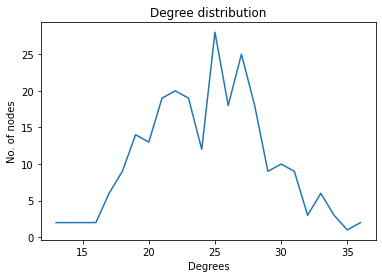

In [4]:
distribution_graph(ER)

**Fig 1. Degree distribution manual implementation**

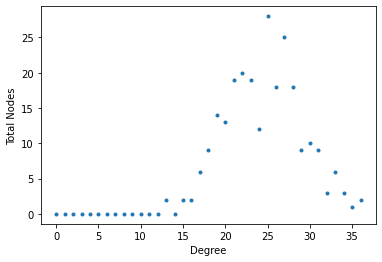

In [5]:
plt.plot(nx.degree_histogram(ER),'.');
plt.xlabel("Degree");
plt.ylabel("Total Nodes");

**Fig 2. Degree Distribution via Networkx**

In a social network with $N$ = 250, we can see that the degree distribution follows a somewhat Binomial Curve, bordering the appearance of a Poisson curve. This will approach a better Poisson curve as the $N$ increases. 

However, while this illustrate how a social network could work, we couldn't conclusively say the same thing in a real world social network. In a real social network, an individual could have no links at all while there may be some that have acquaintances that amount to thousands in a social network platform.

These disrepancies exist because of the following:
- Poisson distributions underestimates the number of high degree nodes.
- The dispersion in the degrees of real networks is much wider than expected in a random network.

Shown below are the degree distributions of real world datasets.

<img src=https://i.imgur.com/LPpHoM5.png>

**Fig 3-5 (from L-R) Internet, Science Collaboration, and Protein Interactions Datasets.** The green line corresponds to the Poisson estimates of the degree distributions by doing a random network model approach to the real-world datasets. It can be noted that the random network model approach significantly underestimates the value of $k$. 

To address these issues, we implement three generative network algorithms for arbitary degrees and real-world networks: **Configuration Model**, **Degree-Preserving Randomization**, and **Hidden Parameter Model**. 

### 1. Configuration Model
The configuration model helps us build a network with nodes having predefined number of degrees but with random connections to each node as shown in the figure below.

<img src = 'https://i.imgur.com/vDO3Gx8.jpg' width=600>
<center><b>Fig 6. Configuration Model with 4 Nodes</b></center>

This type of network model can be useful when analyzing social networks because it allows for arbitary degree distributions.

As per Barabasi, the configuration model's algorithm is as follows:
1. Assign a degree to each node, represented as stubs or half-links. The degree sequence is either generated analytically from a preselected pk distribution (BOX 4.7), or it is extracted from the adjacency matrix of a real network. We must start from an even number of stubs, otherwise we are left with unpaired stubs.
2. Randomly select a stub pair and connect them. Then randomly choose another pair from the remaining 2L - 2 stubs and connect them. This procedure is repeated until all stubs are paired up. Depending on the order in which the stubs were chosen, we obtain different networks. Some networks include cycles (b), others self-loops (c) or multi-links (d). Yet, the expected number of self-loops and multi-links goes to zero in the N → ∞ limit

We implement the configuration model via NetworkX.

In [6]:
z = [4, 5, 4, 2, 6, 4, 2, 3, 2, 6]

sum(z)

38

In [7]:
G = nx.configuration_model(z) 
degree_sequence = [d for n, d in G.degree()]  

In [8]:
hist = {}
for d in degree_sequence:
    if d in hist:
        hist[d] += 1
    else:
        hist[d] = 1
print("degree nodes")
for d in hist:
    print(f"{d:4} {hist[d]:6}")

degree nodes
   4      3
   5      1
   2      3
   6      2
   3      1


<Figure size 1440x1440 with 0 Axes>

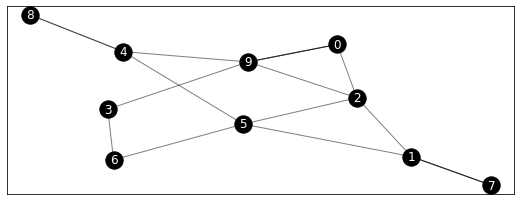

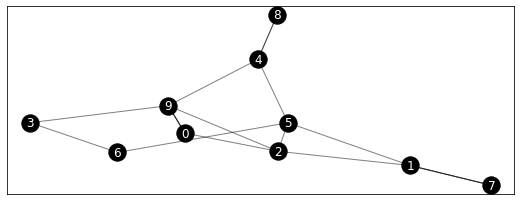

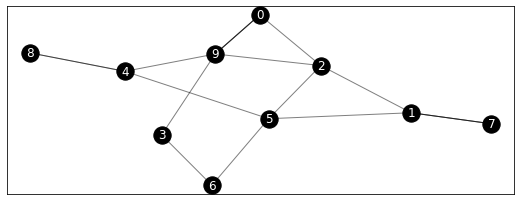

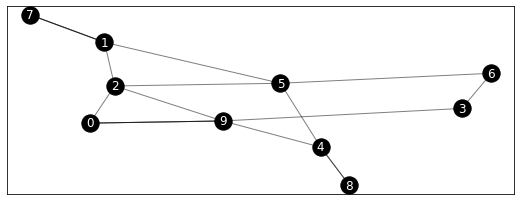

In [9]:
fig = plt.figure(figsize=(20,20));
for i in range(1, 5):
    fig = plt.figure(figsize=(20,20));
    ax = fig.add_subplot(5, 2, i+1);
    pos = nx.fruchterman_reingold_layout(G)
    nc = nx.draw_networkx_nodes(G, pos=pos, node_size=300, cmap=plt.cm.RdYlBu,
                                node_color='black');
    nx.draw_networkx_labels(G, pos, font_color='White');
    nx.draw_networkx_edges(G, pos=pos, alpha=0.500);
    plt.show()


In the first part of the algorithim, degrees were set for each node. In the iterations that follow, random network graphs are generated but the number of degrees per node remain the same.

## 2. Degree-Preserving Randomization

Barabasi states that when trying to model and understand real networks, we must seek to understand if a certain network's property is predicted by its degree distribution only, or if other factors are affecting it. Simply put, if we rewire the networks connection a certain number of ways, it can end up with a way different topology but with the same degree distribution as the original network.

To do this, we implement Degree-Preserving Randomization, wherein nodes in a network have $P_k$ similar to the real-world networks they are being modeled from, but have different and random connections. 

The idea behind Degree-Preserving Randomization is this: two nodes are randomly selected and swap them. These two nodes may or may not form new connections. The degrees of each node are preserved, so in this manner, hubs remain as hubs and small network remain as small networks. 

In a social network, Degree-Preserving Randomization can be used to identify acquaintances up to the second degree. This could be useful in finding out lost relatives or in the context of law enforcement, find connections to a known criminal that may not seem too obvious.

Below we implement Degree Preserving Randomization.

In [10]:
#Generate a network
G = nx.fast_gnp_random_graph(50,0.1)
edges = G.edges()
nodes = G.nodes()

In [11]:
edges

EdgeView([(0, 14), (0, 21), (0, 45), (1, 10), (1, 22), (1, 43), (2, 3), (2, 4), (2, 6), (2, 14), (2, 15), (2, 30), (2, 31), (2, 36), (2, 48), (3, 30), (3, 38), (3, 40), (3, 44), (4, 25), (4, 29), (4, 32), (4, 37), (4, 40), (4, 44), (4, 46), (5, 14), (5, 23), (6, 9), (6, 17), (6, 19), (6, 34), (6, 35), (6, 42), (6, 43), (7, 25), (7, 44), (8, 20), (8, 24), (8, 47), (9, 13), (9, 26), (9, 40), (10, 17), (10, 27), (10, 38), (11, 18), (11, 38), (11, 47), (12, 13), (12, 22), (12, 38), (12, 39), (13, 38), (13, 41), (13, 48), (13, 49), (14, 28), (14, 38), (14, 44), (15, 39), (15, 49), (16, 17), (16, 28), (16, 37), (16, 46), (17, 19), (17, 23), (17, 29), (17, 30), (17, 33), (17, 34), (17, 46), (17, 49), (18, 20), (18, 29), (19, 24), (19, 33), (20, 28), (20, 29), (20, 31), (20, 47), (21, 23), (21, 27), (21, 29), (21, 31), (21, 32), (22, 27), (22, 33), (22, 39), (22, 44), (23, 31), (23, 36), (23, 49), (24, 31), (24, 44), (24, 47), (24, 48), (25, 36), (25, 44), (25, 48), (26, 36), (26, 40), (26, 42

In [12]:
print('Links:', len(edges))
print('Nodes:',len(nodes))

avg_deg = (len(edges)) / len(nodes) 
print('Avg degree:',avg_deg)

Links: 133
Nodes: 50
Avg degree: 2.66


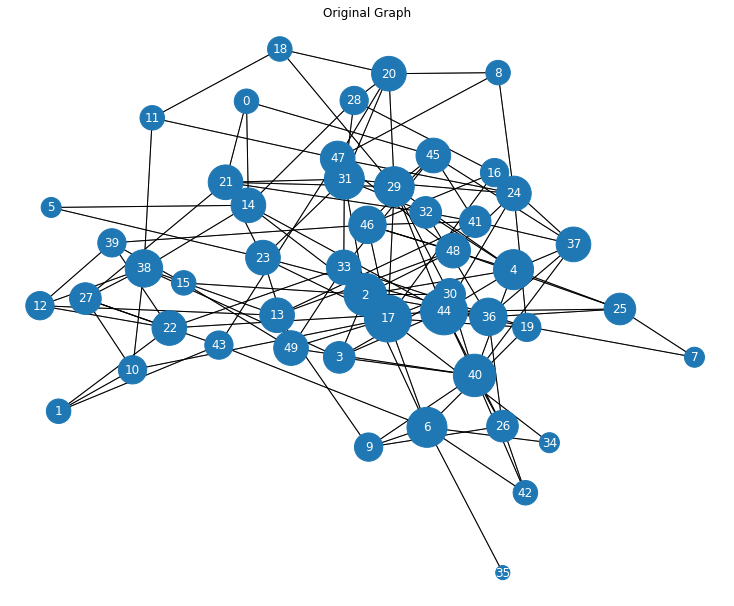

In [13]:
plt.figure(figsize=(10,8))
pos = nx.fruchterman_reingold_layout(G)
nc = nx.draw(G, pos=pos, node_size = [G.degree(i)*200 for i in G.nodes()], 
             cmap=plt.cm.RdYlBu);
nx.draw_networkx_labels(G, pos, font_color='White');
nx.draw_networkx_edges(G, pos=pos, alpha=0.500);
plt.title('Original Graph');

In [14]:
def degree_preserving(edges):
    '''
    Credits to Ben Maier (https://github.com/benmaier)
    
    Implements a degree-preserving randomization network.
    
    Parameters
    ----------
    edges : list
        list of node pairs
        
    Returns
    -------
    new_edges : list
        list of new/swapped node pairs
    '''
    edges = set([tuple(e) for e in edges])
    stubs = [ ]
    [stubs.extend(e) for e in edges]
    stub_counter = Counter(stubs)
    new_edges = set()
    nodes = np.array([stub for stub, count in stub_counter.items() 
                      if count!=0])
    
    while len(nodes) > 0:
        first, second = -1,-1
        
        while first == second and len(nodes)>1:
            first,second = np.random.choice(nodes,size=(2,),replace=False)

        if first!=second and \
           (first,second) not in new_edges and \
           (second,first) not in new_edges and \
           len(nodes)>1:
            new_edges.add((first,second))
            stub_counter[first] -= 1
            stub_counter[second] -= 1
            
        else:
            edge = random.sample(new_edges,1)[0]
            new_edges.remove(edge)
            stub_counter[edge[0]] += 1
            stub_counter[edge[1]] += 1

        nodes = np.array([stub for stub,count in stub_counter.items() 
                          if count!=0 ])

        
    return list(new_edges)


In [15]:
G1 = degree_preserving(edges)

In [16]:
G2 = nx.Graph()
G2.add_edges_from(G1)

Text(0.5, 1.0, 'Degree Preserved Graph')

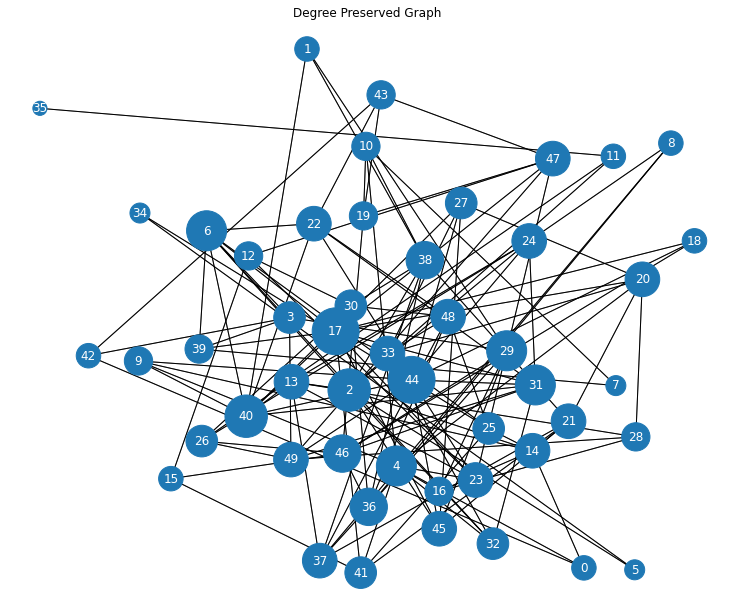

In [17]:
plt.figure(figsize=(10,8))
pos = nx.fruchterman_reingold_layout(G)
nc = nx.draw(G2, pos=pos, node_size = [G2.degree(i)*200 for i in G2.nodes()], 
             cmap=plt.cm.RdYlBu);
nx.draw_networkx_labels(G2, pos, font_color='White');
nx.draw_networkx_edges(G2, pos=pos, alpha=0.500);
plt.title('Degree Preserved Graph')

In [18]:
print('Links:', len(G2.edges()))
print('Nodes:',len(G2.nodes()))

avg_deg = (len(G2.edges())) / len(G2.nodes()) 
print('Avg degree:',avg_deg)

Links: 133
Nodes: 50
Avg degree: 2.66


We can observe despite the differences in topology of the two graphs, the two graphs maintained the same network properties. 

## 3. Hidden Parameter Model

In the hidden parameter, the network to be worked on already has a predefined average $P_k$, and in constructing the network, multi-links and self-loops are omitted as these are often not true in real-world networks. 

In creating the hidden parameter model:
1. Start by $N$ isolated nodes.
2. Attach to each node a hidden parameter that can come from $p(n)$ distribution or is provided by a certain sequence {$η_i$}
3. Draw the networks after connecting the nodes, representing realizations generated by the same hidden parameter sequence.

In [19]:
def hidden_parameter(N, e_k, omega=2.5):
    '''
    Credits to Ulurtuki. https://github.com/uluturki
    
    Generates a hidden parameter model. Function is implementation of 
    Barabasi's Hidden Parameter Model
    
    Parameters
    ----------
    N : int
        number of nodes
    
    e_k : float
        expected degree
        
    omega : float
        expected exponent degree
        
    Returns
    -------
    G : networkx graph
        graph made with hidden parameter model
    '''
    G = nx.empty_graph(N)
    
    ## Equation 4.29
    alpha = 1 / (omega - 1)
    
    harmonic_series = np.power((1 / (np.arange(N) + 1)), alpha)
    c = (e_k * N) / np.sum(harmonic_series)

    # Equation 4.28
    n_list = harmonic_series * c

    n_expected = e_k

    # Assign each node a hidden parameter n_i
    edges = combinations(range(N), 2)
    denominator = (n_expected * N)
    
    for e in edges:
        # Figure 4.18
        p = ((n_list[e[0]] * n_list[e[1]]) / denominator)
        if random.random() < p:
            G.add_edge(*e)
    return G

In [20]:
N = 100       
e_k = 3.15     
omega = 2.5    

G = hidden_parameter(N=N, e_k=3.15, omega=2.5)

For networks with a pre-defined distribution, it is expected that it should form a power law type of distribution. We check it via the following.

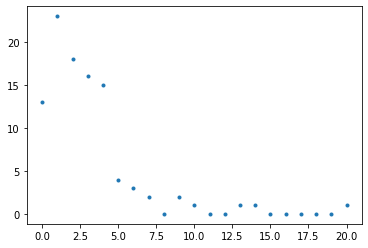

In [21]:
plt.plot(nx.degree_histogram(G),'.');

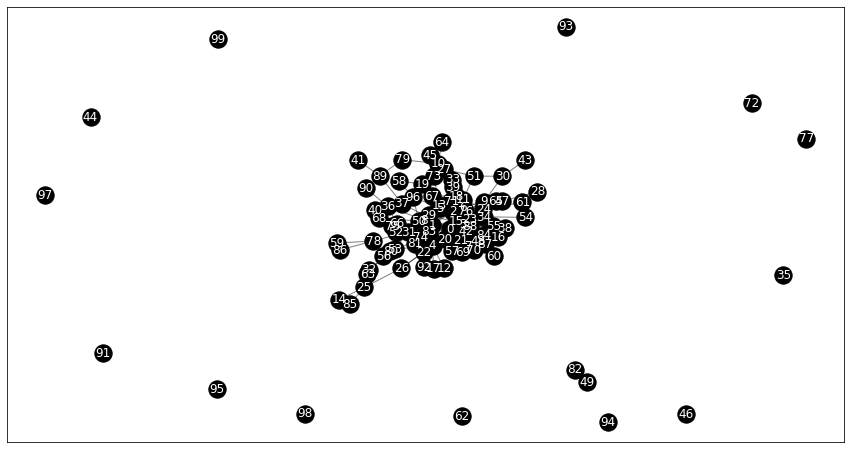

In [22]:
plt.figure(figsize=(15,8))
pos = nx.fruchterman_reingold_layout(G)
nc = nx.draw_networkx_nodes(G, pos=pos, node_size=300, cmap=plt.cm.RdYlBu,
                            node_color='black');
nx.draw_networkx_edges(G, pos=pos, alpha=0.500);
nx.draw_networkx_labels(G, pos=pos, font_color='white');
# plt.title('Random Social Network Graph with p=0.1')
plt.show()

**References**
- Barabasi, Albert-Lazlo. "Network Science: Random Networks." https://barabasi.com/f/624.pdf 
- Barabasi, Albert-Lazlo. "Network Science." http://networksciencebook.com/chapter/4#generating-networks
- https://www.geeksforgeeks.org/implementation-of-erdos-renyi-model-on-social-networks/
- https://github.com/benmaier/Degree-preserving-Randomization
- https://github.com/uluturki/hpm/blob/master/hpm.py